## Import all relevant libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM,Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
abl = pd.read_csv('Input/ABL PA Equity.csv')
abl.head()

,Date,Open,High,Low,Close,Volume
0,2005-08-17,1.4809,7.2563,5.1831,6.2789,38266.0
1,2005-08-18,1.4809,7.2563,5.1831,6.2789,38266.0
2,2005-08-19,6.2789,6.2938,6.1086,6.2789,16582.0
3,2005-08-22,6.2789,6.4418,6.2567,6.3678,73980.0
4,2005-08-23,6.3678,6.3678,6.0494,6.3086,42092.0


## Data Visualization

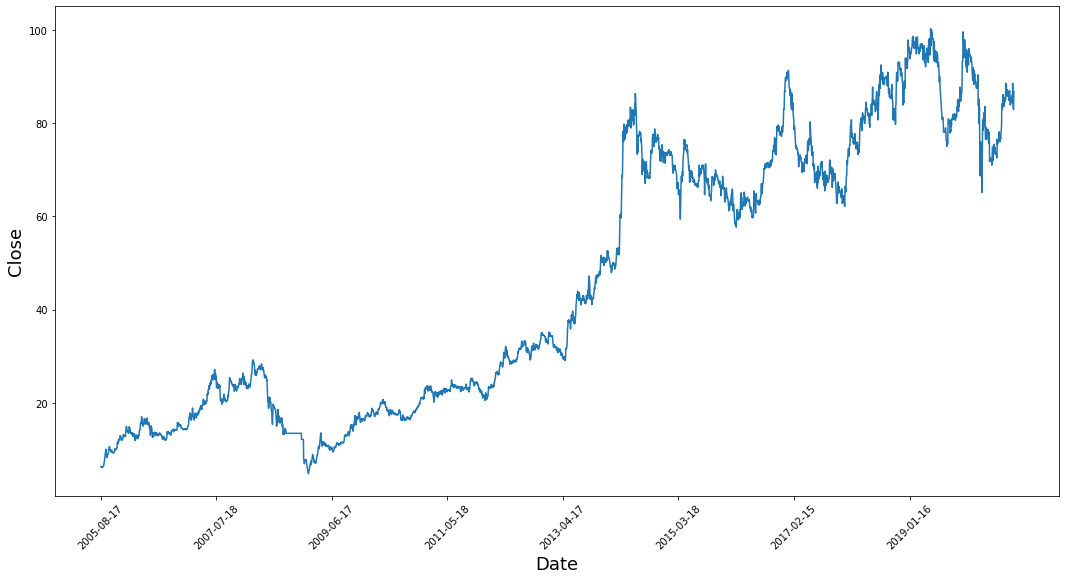

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Close'])
plt.xticks(range(0, abl.shape[0], 500), abl['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

## Test-Train Split

In [4]:
def test_train_split(df):
    close_prices = df['Close'] #We choose to predict the close price
    
    # 80-10-10 split into Train-Validation-Test

    train_data = close_prices[:int(len(close_prices)*0.8)]
    #valid_data = close_prices[int(len(close_prices)*0.8):int(len(close_prices)*0.9)]
    test_data = close_prices[int(len(close_prices)*0.8):]

    train_data = np.asarray(train_data)
    #valid_data = np.asarray(valid_data)
    test_data = np.asarray(test_data)

    train_data = train_data.reshape(-1, 1)
    #valid_data = valid_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)


    print(train_data.shape[0])
    #print(valid_data.shape[0])
    print(test_data.shape[0])
    
    return train_data, test_data
    
train_data, test_data = test_train_split(abl)

3161
791


## Check distribution of data

{'boxes': [<matplotlib.patches.PathPatch at 0x7fa7637ad6d8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fa7637ade10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa761f3b8d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fa761f3b550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fa7637ad978>,
  <matplotlib.lines.Line2D at 0x7fa7637ada90>]}

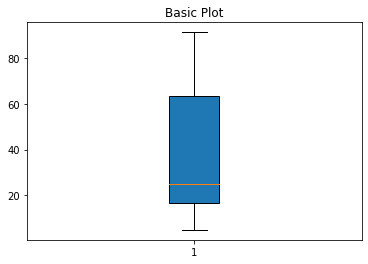

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_data, patch_artist=True)

## Prepare Train set

In [6]:
def train_prep(train_data):

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(60, train_data.shape[0]): #Make windows of 60 days for training until last day

        x_train.append(train_data[i-60:i]) #60 day window
        y_train.append(train_data[i, 0]) #60th day price

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
    
x_train, y_train, scale_train = train_prep(train_data)

(3101, 60, 1) (3101,) [0.01156523]


## Prepare test set

In [7]:
def test_prep(test_data, train_data):
    
    scaler = MinMaxScaler()
    test_data = np.concatenate((train_data[:60], test_data), axis = 0) #Add last 60 observations of train data to test
    test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(60, test_data.shape[0]):
        x_test.append(test_data[i-60:i])
        y_test.append(test_data[i, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
    print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data)

(791, 60, 1) (791,) [0.0106163]


## fbprophet 

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
df = abl
df = df.reset_index()
df[['ds','y']] = df[['Date','Close']]
df = df.drop(['index','Date','Open','High','Low','Close','Volume'], axis=1)
df.head()

,ds,y
0,2005-08-17,6.2789
1,2005-08-18,6.2789
2,2005-08-19,6.2789
3,2005-08-22,6.3678
4,2005-08-23,6.3086


In [12]:
import fbprophet


In [22]:
m = fbprophet.Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1)
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
3948,2020-10-05
3949,2020-10-06
3950,2020-10-07
3951,2020-10-08
3952,2020-10-09


In [23]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3948,2020-10-05,88.922733,81.536249,94.391740,88.922733,88.922733,-1.051871,-1.051871,-1.051871,0.380942,0.380942,0.380942,-1.432814,-1.432814,-1.432814,0.0,0.0,0.0,87.870862
3949,2020-10-06,88.933472,81.184820,94.723972,88.933472,88.933472,-0.988775,-0.988775,-0.988775,0.392161,0.392161,0.392161,-1.380935,-1.380935,-1.380935,0.0,0.0,0.0,87.944698
3950,2020-10-07,88.944212,81.150261,94.802048,88.944212,88.944212,-0.893594,-0.893594,-0.893594,0.434681,0.434681,0.434681,-1.328275,-1.328275,-1.328275,0.0,0.0,0.0,88.050618
3951,2020-10-08,88.954951,81.630501,94.119437,88.954951,88.954951,-0.799505,-0.799505,-0.799505,0.475796,0.475796,0.475796,-1.275301,-1.275301,-1.275301,0.0,0.0,0.0,88.155446
3952,2020-10-09,88.965691,81.479294,94.425465,88.965691,88.965691,-0.698104,-0.698104,-0.698104,0.524343,0.524343,0.524343,-1.222446,-1.222446,-1.222446,0.0,0.0,0.0,88.267587


In [24]:
df.shape


(3952, 2)

In [25]:
forecast.shape

(3953, 19)

In [26]:
df.describe()

,y
count,3952.000000
mean,45.841717
std,29.008364
min,4.833600
25%,18.391975
50%,33.406050
75%,73.433525
max,100.266400


In [27]:
forecast.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.0,3953.0,3953.0,3953.000000
mean,45.426620,39.292496,52.406560,45.426620,45.426620,0.426054,0.426054,0.426054,0.441612,0.441612,0.441612,-0.015558,-0.015558,-0.015558,0.0,0.0,0.0,45.852674
std,28.428827,28.452680,28.446240,28.428827,28.428827,1.076627,1.076627,1.076627,0.053273,0.053273,0.053273,1.075337,1.075337,1.075337,0.0,0.0,0.0,28.446231
min,8.360960,0.418531,13.725236,8.360960,8.360960,-1.460609,-1.460609,-1.460609,0.380942,0.380942,0.380942,-1.841552,-1.841552,-1.841552,0.0,0.0,0.0,7.477693
25%,18.358826,12.174055,25.288647,18.358826,18.358826,-0.461262,-0.461262,-0.461262,0.392161,0.392161,0.392161,-0.903352,-0.903352,-0.903352,0.0,0.0,0.0,18.688436
50%,33.071950,27.172876,40.334848,33.071950,33.071950,0.475984,0.475984,0.475984,0.434681,0.434681,0.434681,0.036436,0.036436,0.036436,0.0,0.0,0.0,33.762609
75%,73.405225,67.678171,80.755932,73.405225,73.405225,1.385104,1.385104,1.385104,0.475796,0.475796,0.475796,0.943385,0.943385,0.943385,0.0,0.0,0.0,74.090592
max,88.965691,83.311273,96.382982,88.965691,88.965691,2.254778,2.254778,2.254778,0.524343,0.524343,0.524343,1.730435,1.730435,1.730435,0.0,0.0,0.0,89.459685


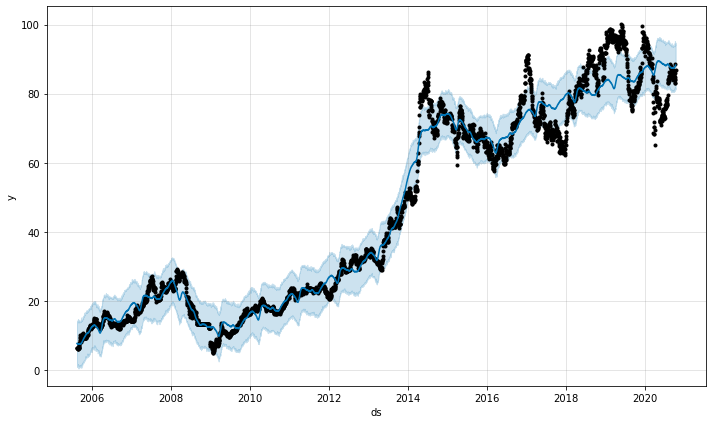

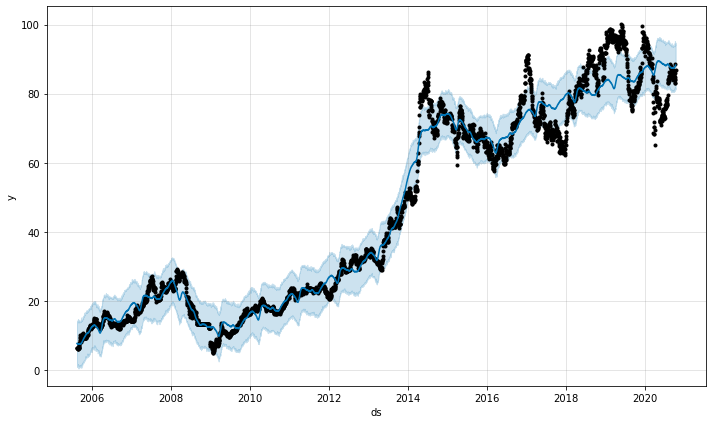

In [28]:
m.plot(forecast)

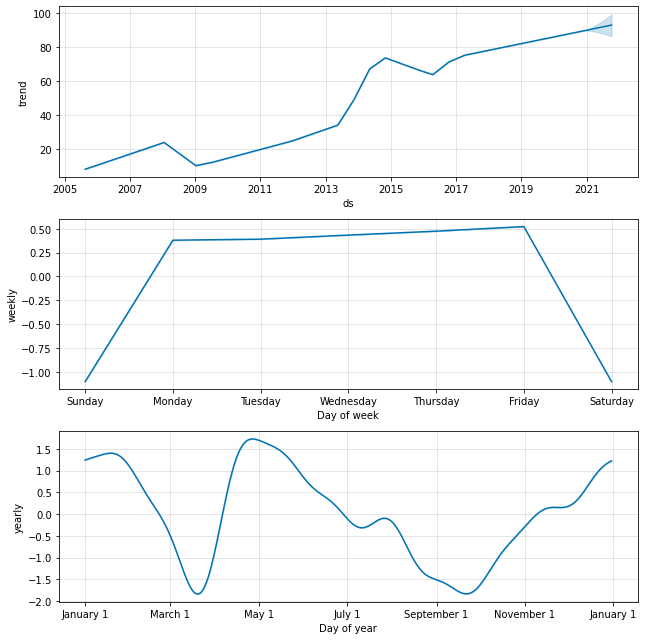

In [21]:
m.plot_components(forecast)


In [30]:
from sklearn.metrics import mean_squared_error


In [32]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)


In [34]:
r2_score(metric_df.y, metric_df.yhat)


0.9687433464831167

In [33]:
mean_squared_error(metric_df.y, metric_df.yhat)


26.295355321944513